In [1]:
# Datos
pr_era5_1 = readRDS('../../data/npd_s_w/pr_npds_era5_1.rds')
pr_seas5_1 = readRDS('../../data/npd_s_w/pr_npds_seas5_1.rds')
pr_seas5_1_bc = readRDS('../../data/npd_s_w/pr_npds_seas5_1_bc.rds')

In [2]:
library(transformeR)
library(ggplot2)
library(dplyr)
library(reshape2)


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded


Get the latest stable version (2.2.3) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# 1. Definir una función auxiliar para convertir el Grid de climate4R a Data Frame
# Esta función aplana el array multidimensional y etiqueta el dataset
grid_to_df <- function(grid, name_dataset) {
  
  # Extraemos los datos numéricos
  data_array <- grid$Data
  
  # Usamos melt para convertir el array 4D (member, time, lat, lon) a una tabla larga
  # na.rm = TRUE elimina los valores fuera de la máscara (el mar, si hay NAs)
  df <- reshape2::melt(data_array, value.name = "Precipitacion")
  
  # Añadimos columna con el nombre del dataset
  df$Dataset <- name_dataset
  
  # Limpieza simple: nos quedamos solo con la columna de precipitación y dataset
  # (Si necesitas filtrar por fecha o lat/lon, tendrías que cruzar con grid$xyCoords o grid$Dates)
  return(df %>% select(Dataset, Precipitacion))
}

# 2. Convertir tus 3 objetos a Data Frames
# NOTA: Puede tardar un poco si los grids son muy grandes (muchos años/miembros)
df_era5   <- grid_to_df(pr_era5_1, "ERA5")
df_seas5  <- grid_to_df(pr_seas5_1, "SEAS5")
df_seas5_bc <- grid_to_df(pr_seas5_1_bc, "SEAS5_BC")

# 3. Unir todo en un solo gran Data Frame
df_total <- bind_rows(df_era5, df_seas5, df_seas5_bc)

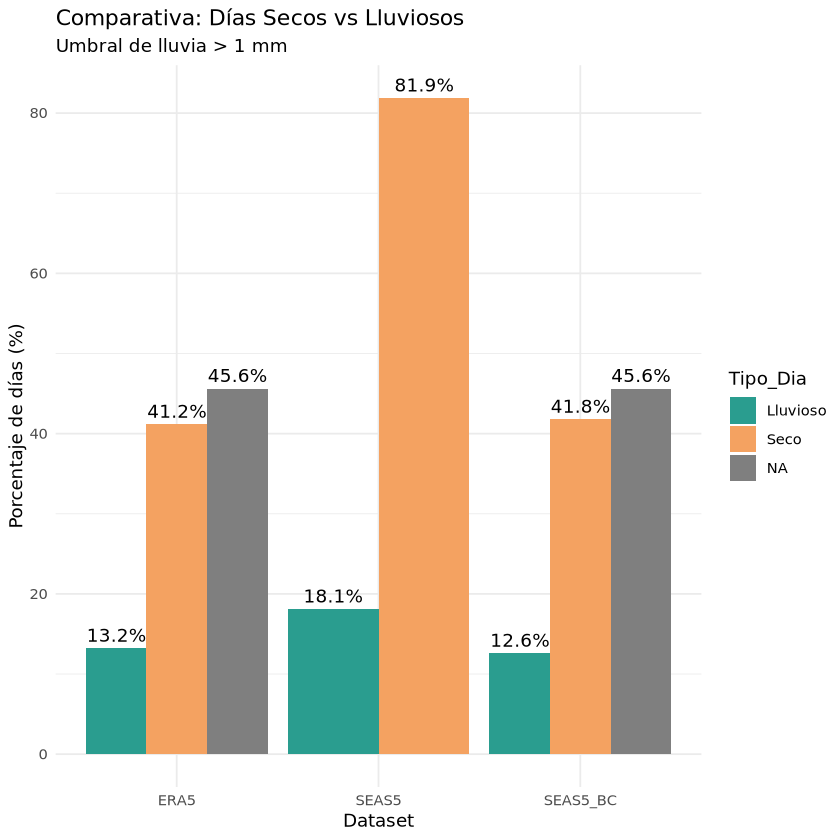

In [4]:
# ---------------------------------------------------------
# ANÁLISIS 1: DÍAS SECOS VS LLUVIOSOS
# ---------------------------------------------------------

# Definimos umbral (ej. 1mm estándar WMO)
umbral_lluvia <- 1.0

df_total <- df_total %>%
  mutate(Tipo_Dia = ifelse(Precipitacion >= umbral_lluvia, "Lluvioso", "Seco"))

# Calculamos porcentajes para que sea comparable (ya que SEAS5 tiene 25 miembros y ERA5 solo 1)
conteo_dias <- df_total %>%
  group_by(Dataset, Tipo_Dia) %>%
  summarise(Conteo = n(), .groups = 'drop') %>%
  group_by(Dataset) %>%
  mutate(Porcentaje = Conteo / sum(Conteo) * 100)

# Gráfica 1: Barras apiladas o separadas de Seco/Lluvioso
p1 <- ggplot(conteo_dias, aes(x = Dataset, y = Porcentaje, fill = Tipo_Dia)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_manual(values = c("Seco" = "#f4a261", "Lluvioso" = "#2a9d8f")) +
  geom_text(aes(label = sprintf("%.1f%%", Porcentaje)), 
            position = position_dodge(width = 0.9), vjust = -0.5) +
  labs(title = "Comparativa: Días Secos vs Lluviosos",
       subtitle = paste("Umbral de lluvia >", umbral_lluvia, "mm"),
       y = "Porcentaje de días (%)") +
  theme_minimal()

print(p1)

ggsave(filename = "grafica_frecuencia_dias.png", 
       plot = p1, 
       width = 10,
       height = 6,
       dpi = 300,
       bg = "white")

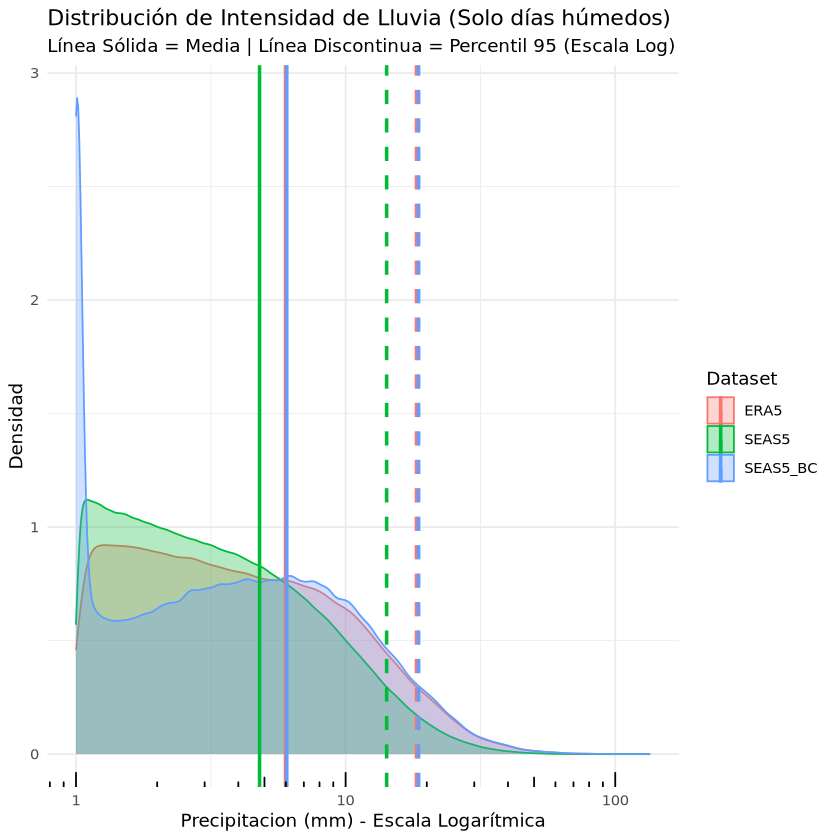

In [5]:
# ---------------------------------------------------------
# ANÁLISIS 2: DISTRIBUCIÓN (CORREGIDO)
# ---------------------------------------------------------

# Filtramos solo los días lluviosos
df_lluvia <- df_total %>% filter(Tipo_Dia == "Lluvioso")

# Calculamos estadísticas
stats_lluvia <- df_lluvia %>%
  group_by(Dataset) %>%
  summarise(
    Media = mean(Precipitacion, na.rm = TRUE),
    P95 = quantile(Precipitacion, 0.95, na.rm = TRUE)
  )

# Gráfica 2: Densidad corregida
p2 <- ggplot(df_lluvia, aes(x = Precipitacion, fill = Dataset, color = Dataset)) +
  geom_density(alpha = 0.3) +
  
  # CORRECCIÓN 1: Usamos linewidth en lugar de size
  geom_vline(data = stats_lluvia, aes(xintercept = Media, color = Dataset), 
             linetype = "solid", linewidth = 1) +
  geom_vline(data = stats_lluvia, aes(xintercept = P95, color = Dataset), 
             linetype = "dashed", linewidth = 1) +
  
  # CORRECCIÓN 2: Manejo de ejes
  # Opción A: Escala normal pero más amplia (descomenta si prefieres lineal)
  # scale_x_continuous(limits = c(0, 150)) + 
  
  # Opción B: Escala Logarítmica (Recomendada para precipitación)
  # Permite ver la "cola" de la distribución sin perder detalle en valores bajos
  scale_x_log10(labels = scales::comma) + 
  annotation_logticks(sides = "b") + # Añade marcas de logaritmo abajo
  
  labs(title = "Distribución de Intensidad de Lluvia (Solo días húmedos)",
       subtitle = "Línea Sólida = Media | Línea Discontinua = Percentil 95 (Escala Log)",
       x = "Precipitacion (mm) - Escala Logarítmica",
       y = "Densidad") +
  theme_minimal()

print(p2)

ggsave(filename = "grafica_intensidad_lluvia.png", 
       plot = p2, 
       width = 10, 
       height = 6, 
       dpi = 300,
       bg = "white")